<a href="https://colab.research.google.com/github/dimahdera/COS-IMGS-389-Spring-2024/blob/main/HW1_Q4_MLP_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Implementation of Multilayer Perceptrons
:label:`sec_mlp-implementation`

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.


In the code below we use `tf.Variable`
to define the model parameter.


In [3]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = tf.Variable(
            tf.random.normal((num_inputs, num_hiddens)) * sigma)
        self.b1 = tf.Variable(tf.zeros(num_hiddens))
        self.W2 = tf.Variable(
            tf.random.normal((num_hiddens, num_outputs)) * sigma)
        self.b2 = tf.Variable(tf.zeros(num_outputs))

In [4]:
class MLPScratch_constant_initialization(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = tf.Variable(initial_value=tf.constant(1., dtype=tf.float32, shape=(num_inputs, num_hiddens)), trainable=True)
        self.b1 = tf.Variable(tf.zeros(num_hiddens))
        self.W2 = tf.Variable(initial_value=tf.constant(1., dtype=tf.float32, shape=(num_hiddens, num_outputs)), trainable=True)
        self.b2 = tf.Variable(tf.zeros(num_outputs))

In [5]:
class MLPScratch_zero_initialization(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = tf.Variable(tf.zeros(shape=(num_inputs, num_hiddens)))
        self.b1 = tf.Variable(tf.zeros(num_hiddens))
        self.W2 = tf.Variable(tf.zeros(shape=(num_hiddens, num_outputs)))
        self.b2 = tf.Variable(tf.zeros(num_outputs))

### Model

To make sure we know how everything works,
we will [**implement the ReLU activation**] ourselves
rather than invoking the built-in `relu` function directly.


In [6]:
def relu(X):
    return tf.math.maximum(X, 0)

Since we are disregarding spatial structure,
we `reshape` each two-dimensional image into
a flat vector of length  `num_inputs`.
Finally, we (**implement our model**)
with just a few lines of code. Since we use the framework built-in autograd this is all that it takes.


In [7]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = tf.reshape(X, (-1, self.num_inputs))
    H = relu(tf.matmul(X, self.W1) + self.b1)
    return tf.matmul(H, self.W2) + self.b2

@d2l.add_to_class(MLPScratch_constant_initialization)
def forward(self, X):
    X = tf.reshape(X, (-1, self.num_inputs))
    H = relu(tf.matmul(X, self.W1) + self.b1)
    return tf.matmul(H, self.W2) + self.b2

@d2l.add_to_class(MLPScratch_zero_initialization)
def forward(self, X):
    X = tf.reshape(X, (-1, self.num_inputs))
    H = relu(tf.matmul(X, self.W1) + self.b1)
    return tf.matmul(H, self.W2) + self.b2

### Training

Fortunately, [**the training loop for MLPs
is exactly the same as for softmax regression.**] We define the model, data, and trainer, then finally invoke the `fit` method on model and data.


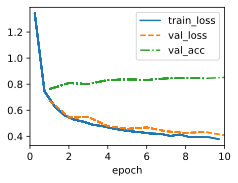

In [8]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

**MLP with Zero Initialization for the Fashion MNIST dataset**

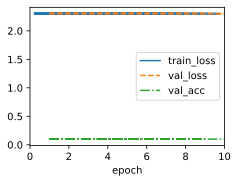

In [9]:
model = MLPScratch_zero_initialization(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.001)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

**MLP with constant Initialization for the Fashion MNIST dataset**

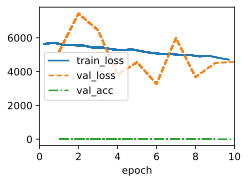

In [10]:
model = MLPScratch_constant_initialization(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.001)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Concise Implementation

As you might expect, by relying on the high-level APIs, we can implement MLPs even more concisely.

### Model

Compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.


In [11]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs)])

Previously, we defined `forward` methods for models to transform input using the model parameters.
These operations are essentially a pipeline:
you take an input and
apply a transformation (e.g.,
matrix multiplication with weights followed by bias addition),
then repetitively use the output of the current transformation as
input to the next transformation.
However, you may have noticed that
no `forward` method is defined here.
In fact, `MLP` inherits the `forward` method from the `Module` class (:numref:`subsec_oo-design-models`) to
simply invoke `self.net(X)` (`X` is input),
which is now defined as a sequence of transformations
via the `Sequential` class.
The `Sequential` class abstracts the forward process
enabling us to focus on the transformations.
We will further discuss how the `Sequential` class works in :numref:`subsec_model-construction-sequential`.


### Training

[**The training loop**] is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.


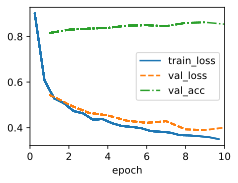

In [12]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

**MLP Concise Implementation with Zero Initialization**

In [15]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, kernel_initializer='zeros',
    bias_initializer='zeros', activation='relu'),
            tf.keras.layers.Dense(num_outputs, kernel_initializer='zeros',
    bias_initializer='zeros')])

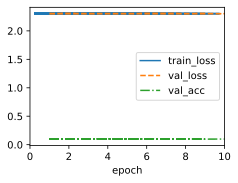

In [16]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

**MLP Concise Implementation with constant Initialization**

In [19]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, kernel_initializer=tf.keras.initializers.Constant(1.),
    bias_initializer='zeros', activation='relu'),
            tf.keras.layers.Dense(num_outputs, kernel_initializer=tf.keras.initializers.Constant(1.),
    bias_initializer='zeros')])

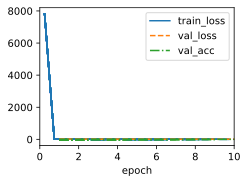

In [20]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)